# Interpretable Machine Learning Tutorial for Earth Scientists

## Outline

Introduction --> introduce problem
Methodology --> introduce the ML models
ML Workflow --> explain and produce (code) the ML workflow
conclusion --> interpretability is necessary and simpler models sometimes work just as well as complex models. And think about the math!

## Introduction

Earth science data often varies temporally, varies spatially, and contains lots of noise due to instruments that record the data. …..

However, with increasing climate instability it is of critical importance to both understand how environmental variables influence earth surface processes and to extract predictive models from available data. Here, I focus on marsh sedimentation which is the process that builds our coastlines and combats land loss due to relative sea level rise. 

The data was collected from a combination of the Coasta Reference Monitoring System (CRMS) andCoastal Information Management System (CIMS) websites. Additionally, I have added my own remote sensing and GIS variables derived from Google Earth Engine (NDVI and total suspended sediment estimates) and ArcMap (Distance to water and rivers). You can find them in the links below:

CRMS: https://www.lacoast.gov/chart/Charting.aspx?laf=crms&tab=2
CIMS: https://cims.coastal.louisiana.gov/monitoring-data/

Due to the focus of this tutorial being one of ML implementation rather than one of exploratory analysis and data cleaning, I have done the justice of precompiling the dataset by excluding irrelevant variables, removing outliers, log transforming the distance variabels (which exhibited logarithmic distributions). However, one should note that the preprocessing part of any ML workflow is one of THE most important parts of any project.

In [88]:
# import all packages
import pandas as pd 
import numpy as np 
import textwrap 

import seaborn as sns 
import matplotlib.pyplot as plt 

import shap 

from sklearn.preprocessing import StandardScaler 
from sklearn import linear_model 

from sklearn.model_selection import KFold, cross_validate, cross_val_predict, RepeatedKFold, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error 


import statsmodels.api as sm

## Descriptive Statistics

An important part of any ML workflow is understanding your data. How is it distributed? How many variables do you have? How many samples? etc.

Because I have already done transformations to variables and outlier removal to this dataset, we are only get to get ssome basic descriptive statistics for this dataset. But pleasse note that preproccessing of data is the MOST important part of ANY machine learning workflow

In [89]:
# end when a "new df" is made 

In [90]:
# read in dataset
df = pd.read_csv(r"/Users/etiennechenevert/Documents/fall2022/ESIP_tutorial/AGU_dataset.csv", 
                encoding="unicode_escape")
print(df.columns) # lets see what variables we are working with

Index(['CRMS Site', 'Accretion Rate (mm/yr)', 'Soil Salinity (ppt)',
       'Soil Moisture Content (%)', 'Bulk Density (g/cm3)',
       'Organic Matter (%)', 'Organic Density (g/cm3)',
       'Soil Porewater Temperature (Â°C)', 'Soil Porewater Salinity (ppt)',
       'Average Height Dominant (cm)', 'Average Height Herb (cm)', 'NDVI',
       'tss_med_mg/l', 'windspeed', 'Average_Marsh_Elevation (ft. NAVD88)',
       'Tide_Amp (ft)', 'avg_flooding (ft)', '90%thUpper_flooding (ft)',
       '10%thLower_flooding (ft)', 'std_deviation_avg_flooding (ft)',
       'avg_percentflooded (%)', 'land_lost_km2', 'log_distance_to_water_km',
       'log_distance_to_river_km', 'Community'],
      dtype='object')


In [91]:
# lets know how many variables and how many samples we have to work with
print("Number of samples in dataset: ", len(df))
print("Number of features in the dataset: ", len(df.columns) )

Number of samples in dataset:  252
Number of features in the dataset:  25


Using our own knowledge about our domain of science can help us get the most out of machine learning experiments. Our dataset contains some variables that are highly correlated together and may even be representing the same environmental variable. For instance, the average height of the dominant vegetation type ('Average Height Dominant (cm)') and the average height of herbaceous vegetation ('Average Height Herb (cm)') likely encode the same information in many areas of the marsh that have herbaceous vegetation as the dominant vegetation type. Therefore, I will remove the variable for the height of herbacous vegetation becasue it is less information than the one for the dominant vegetation type. Another example is the Bulk Density (g/cm3) variable because this variable essentially just describes the density of accreted sediment. So, if bulk density were to be a significant predictor in our modle what would it tell us? Not much other than more mineral sedimentation (higher bulk density) leads to more accretion or, however unlikely, the opposite. This doesn't really describe a process though. I remove bulk density, organic matter (%), soil moisture (%), and organic density because they all record what the accreted sediment is rather than a environmental factor associated with it.

Marsh Elevation is removed because it is less related to a proccess than other variables that shoould encompass it such as flood depth and position in the tidal frame (tidal amplitude). Soil porewater temperature was a tricky variable for me. I decided to remove it because my knowledge regarding it is limited, however, it does record some interesting relationships with accretion. 

In [92]:
# There are some unnecessary and/or uninformative variables in here, so lets remove them
df = df.drop([
    'Average Height Herb (cm)', 'Soil Salinity (ppt)', 'Soil Moisture Content (%)', 'Bulk Density (g/cm3)',
    'Organic Matter (%)', 'Organic Density (g/cm3)', 'Average_Marsh_Elevation (ft. NAVD88)',
    'Soil Porewater Temperature (Â°C)'
], axis=1)

In [93]:
outcome = 'Accretion Rate (mm/yr)'
feature_ls = list(df.columns.values[1:-1]) # make a list including all the variables; excluding the categorical Site and Maarsh community variables
print(feature_ls) # looks good; great!

['Accretion Rate (mm/yr)', 'Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI', 'tss_med_mg/l', 'windspeed', 'Tide_Amp (ft)', 'avg_flooding (ft)', '90%thUpper_flooding (ft)', '10%thLower_flooding (ft)', 'std_deviation_avg_flooding (ft)', 'avg_percentflooded (%)', 'land_lost_km2', 'log_distance_to_water_km', 'log_distance_to_river_km']


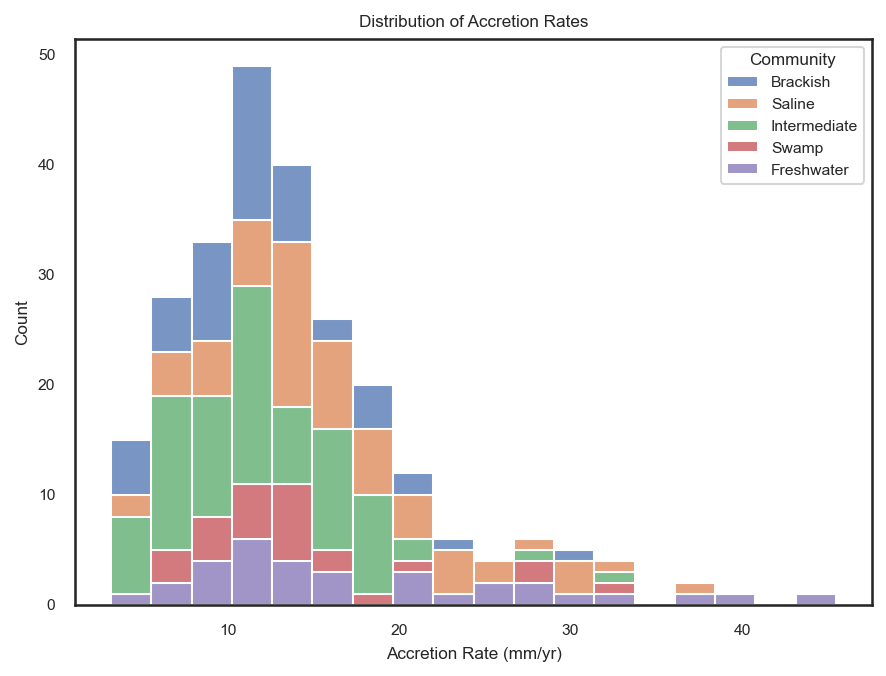

In [94]:
# Lets visualize what we want to predict, 'Accretion Rate (mm/yr)'
f = plt.figure(figsize=(7, 5))
ax = f.add_subplot(1, 1, 1)
sns.histplot(data=df, ax=ax, stat="count", multiple="stack",
             x="Accretion Rate (mm/yr)", kde=False,
             hue="Community",
             element="bars", legend=True)
ax.set_title("Distribution of Accretion Rates")
ax.set_xlabel("Accretion Rate (mm/yr)")
ax.set_ylabel("Count")
plt.show()

In [95]:
# lets define our target and design matrix for our ML job
target = df[outcome]
phi = df[feature_ls].drop('Accretion Rate (mm/yr)', axis=1)

In [96]:
# Pandas as an eassy to use method to get a feel for the data
target.describe()

count    252.000000
mean      14.075322
std        7.115724
min        3.208008
25%        9.145631
50%       12.640623
75%       16.850584
max       45.472917
Name: Accretion Rate (mm/yr), dtype: float64

In [97]:
phi.describe()

,Soil Porewater Salinity (ppt),Average Height Dominant (cm),NDVI,tss_med_mg/l,windspeed,Tide_Amp (ft),avg_flooding (ft),90%thUpper_flooding (ft),10%thLower_flooding (ft),std_deviation_avg_flooding (ft),avg_percentflooded (%),land_lost_km2,log_distance_to_water_km,log_distance_to_river_km
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,6.487123,107.968194,0.366748,30.848057,6.594315,0.333359,0.129325,0.824704,-0.578861,0.563690,44.586944,0.051248,0.152819,1.281989
std,5.792141,23.198471,0.113854,13.602300,0.416185,0.299195,0.365486,0.328567,0.515562,0.131047,27.227388,0.088283,0.479526,0.448464
min,0.100000,42.670000,0.099034,0.000000,5.269485,0.001983,-0.970000,0.043000,-2.111000,0.210000,0.000000,0.000000,-1.535129,-0.794207
25%,1.600000,94.790000,0.298098,28.545964,6.445041,0.033593,-0.082500,0.608125,-0.892500,0.480000,25.544243,0.000000,-0.054172,1.019580
50%,4.800000,105.580000,0.369623,32.812757,6.692204,0.252224,0.125000,0.810750,-0.598250,0.560000,47.645698,0.014730,0.075249,1.397769
75%,9.775000,119.480000,0.446556,39.326984,6.860730,0.626801,0.360000,1.041000,-0.249125,0.656250,63.227168,0.065379,0.550120,1.610944
max,22.100000,190.800000,0.627081,58.441428,7.315856,0.902236,1.270000,1.968000,0.848500,0.890000,99.999999,0.580248,1.001912,1.873717


In [98]:
# lets visualize 

## Interpretable ML: Models and Methods

There are many different ML models to choose from, but not all are equally interpretable. In this tutorial I will exhibit how to use Bayesian Ridge Regression and Extreme Gradient Boosting (XGBoost) models for this particular dataset.

### Bayesian Ridge Regression

A Bayesian ridge regression model is simply multiple linear regression model with a L2 regularization term from a bayesian treatment. The Bayesian treatment differs from the frequentist treatment of multplie linear regression in that it deals with probability distributions. Let's review linear regression to get an understanding of where bayesian linear regression and linear regression differ.

Lets recall what linear regression looks like:

$$ y = \omega_0 + \omega_1 x_1 + \omega_2 x_2 ... \omega_k x_k \label{eq1}\tag{1}$$

Where $w_0$ is a bias parameter (or the intercept) which can be initialized to 1 for simplicity in the derivation. 

In linear algebra form, this can also be written simpler like this: $ y = X \omega$, where $\omega$ is the vector that encompasses all the terms ${w_0, w_1, ..., w_k}$ and $X$ is the matrix of predictor variables. However, we still do not know the values in our weight vector and we need to solve for them. If we assume that our target variable $t$ is drawn independently and determined by a linear function with some added gaussian noise, then it should be a random sample of this normal distribution:

$$ p(t|w, \beta) = {\displaystyle \prod_{n=1}^{N} \mathcal{N}(t_n | \omega^T \phi(x_n)), \beta^-1} \label{eq2}\tag{2}$$

This is called the likelihood function of $t$ and it follow a normal distribution, so it looks like this: https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.istockphoto.com%2Fphotos%2Fbell-curve&psig=AOvVaw1FlfWvVa79oTo8xRv2i4vf&ust=1669957941698000&source=images&cd=vfe&ved=0CA4QjRxqFwoTCMiopaDU1_sCFQAAAAAdAAAAABAE

Explicitly we can write it as:

$$ p(y |w, \beta) ....$$

We then need to maximize the likelihood function because we want the weight vector that maximizes the probability of the target variable. In other words, we want our weight vector to give us the most probable estimate for $t$. So let's think, where on the curve is the most likely estimate for $t$? It would be at the highest point! Which in a normal distribution is assocaited with the mean and is the only place in which the derivative of the function is zero. So let's take the derivative of the likelihood function w.r.t $\omega$ and we get:

$$ ln p(t|w, \beta) = \frac{N}{2} ln \beta - \frac{N}{2} ln(2\pi) - \beta E_D(\omega) \label{eq3}\tag{3}$$

I know this might look intmidating, but bare with me, it is good to be at least familiar with the mathematical fundations of any ML model you are working with.....


## The Machine Learning Workflow

Great! Now we know the math behind Bayesian Ridge Regression. Luckily, we don't have to create an algorithm to compute everything we derived above because someone, scikit-learn's team, have already made an easy to use implementation of the Bayesian Ridge Regression. See this link for more details: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.BayesianRidge.html

First, let's understand what we want from this model. We want to know (1) the relative importance of each variable, (2) the coefficients of the weight vector, and (3) the model uncertaainties over both predictions and parameters.

Let's focus on numbers one and two first. To get the relative importance of the variables, we cannot simply use the variables as they are because each variable lies on a different scale. For example, if we find the coefficents on unscaled predictors we may over estimate the importance of variables that lie on small scales becuase I "one unit increase in $x_n$" might actually be a drastic change to the environment. I good example is NDVI, which lies between 0 and 1, so a "one unit increase in NDVI" actually means that the environment has gone from completely barren to very densley vegetated! On the other hand, finding the coefficents for the unscaled predictors is useful in that we can easily interpret the coefficent as "a one unit increase in $x_n$ results in a ___ increase in %t%"

To get the best of both worlds: feature importance from scaled predictors and easy interpretation from unscaled predictors. We need to train the model on the scaled features, then invert the coefficents back to their unscaled values. To do this, we only need to rearrange the line regression equation from equation (1):

$$$$




In [99]:
# Lets begin the implementation
# First, as I noted above, we need to scale the predictors in order to extract feature importances in 
scalar_Xwhole = StandardScaler()
predictors = pd.DataFrame(scalar_Xwhole.fit_transform(phi), columns=phi.columns.values)

In [100]:
# Now lets make a simple function that can invert the weight scales
def unscaled_weights_from_Xstandardized(X, bayesianReg: linear_model):
    """
    This code only works for Bayesian Ridge Regression
    https://stackoverflow.com/questions/57513372/can-i-inverse-transform-the-intercept-and-coefficients-of-
    lasso-regression-after
    Better source:
    https://stats.stackexchange.com/questions/74622/converting-standardized-betas-back-to-original-variables
    """
    a = bayesianReg.coef_
    i = bayesianReg.intercept_
    # Me tryna do my own thing
    coefs_new = []
    for x in range(len(X.columns)):
        # print(X.columns.values[x])
        col = X.columns.values[x]
        coefs_new.append((a[x] / (np.asarray(X.std()[col]))))
    intercept = i - np.sum(np.multiply(np.asarray(coefs_new), np.asarray(X.mean())))  # hadamard product

    return coefs_new, intercept

#### Feature Selection

Feature selection is the process of removing variables that do not add predictive power to the model to decrease the models complexity. In a linear regression model, too many variables can lead to overfitting so it is good practice to only choose variables that are essential and to not just throw everything into the model. Although, the Bayesian Ridge Regression has a L2 regularization term, there is only so much this term can do to reduce overfitting. Therefore, let's employ a simple feature selection algorithm called backward feature elimination.

My backward feature elmination algorithm fits a Ordinary Least Squares linear regression to all the data, calculates the p-value of every predictor variable, removes the predictor with the highest p-value from the dataset, then repeats until all predictors are significant based on a p-value less than 0.05. 

In [101]:
def backward_elimination(data, target, num_feats=5, significance_level=0.05):
    """
    Code is adapted from: 
    https://www.analyticsvidhya.com/blog/2020/10/a-comprehensive-guide-to-feature-selection-using-wrapper-methods-in-python/#:~:text=1.-,Forward%20selection,with%20all%20other%20remaining%20features.
    """
    features = data.columns.tolist()
    target = list(target)
    while(len(features)>0):
        features_with_constant = sm.add_constant(data[features])
        p_values = sm.OLS(target, features_with_constant).fit().pvalues[1:]
        max_p_value = p_values.max()
        if(max_p_value >= significance_level) or (len(features) > num_feats):
            excluded_feature = p_values.idxmax()
            features.remove(excluded_feature)
        else:
            break
    return features


bestfeatures = backward_elimination(data=predictors, target=target, num_feats=10, significance_level=0.05)
print(bestfeatures)

['Soil Porewater Salinity (ppt)', 'tss_med_mg/l', 'Tide_Amp (ft)', 'avg_flooding (ft)']


In [102]:
# Lets use these selected features to define our ML dataset
X, y = predictors[bestfeatures], target
# initialize scikit learn's model
baymod = linear_model.BayesianRidge(fit_intercept=True)

## Bayesian Ridge Regression Implementation

### Model Performance Evaluation and Cross Validation

In order to accurately assess the performance of our model, we need to test it on data it was not trained on. The simplest way to do this is to split the dataset into two parts, a train set and a test set, then test how accurately the model can predict the target of the test set given the values of $X$ of the test set. However, this only accurately captures the full variability of the dataset if our dataset is large enough that the test set is of the same distribution as the test set. In small dataset applications, we often can not confidently say that the the test set will always be an appropriate representation of the data in the train set. For example, consider a dataset like this:

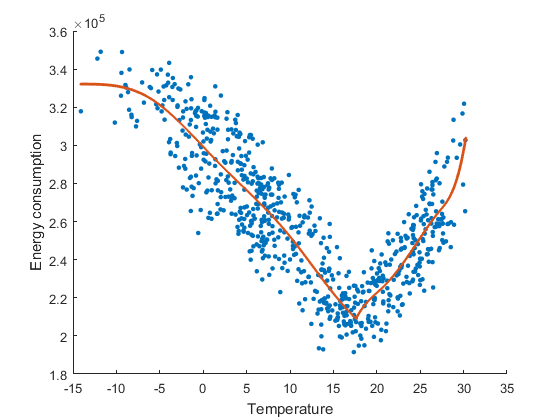

Source: https://www.researchgate.net/publication/335617611_Testing_nonparametric_shape_restrictions/figures?lo=1&utm_source=google&utm_medium=organic

If we make the train set as temperature < 20 and the test set temperature >= 20, then we will get awful model perforamnces because we have learned the parameters for a relationship that very ill fit for temperature >= 20! This could also go the other way in that we can get overly optimistic results. Therefore, it is important to cross validate to obtain the true model performance on all subsets of the data.

To conduct cross validation, we need to split the dataset into $K$ number of folds. We then train the model on $k-1$ folds, then test on the fold left out. We then repeat the process $K$ times, alternating the fold we test on, and then we average the results. This is called "K-fold cross validation."

-----> insert a figure of cross validation ---------->

Another similar method for evaluating general model perforamnce is called "Repeated K-fold Cross Validation." This method is exactly the same except after we average the results of the K-folds, we then repeat the whole process again with a different set of K-folds, then average those results. This can repeat as many times as the user wants, but generally after 50 or 100 repeats we have trained and tested the model on all data points. 

In the below implementation I write code to do 100x repeated 5-fold cross validation, which effectively trains 500 models. I save the results and learned parameters of these models and report the range and averages of them. This gives us a robust sense of what the model is learning and how it is performing.

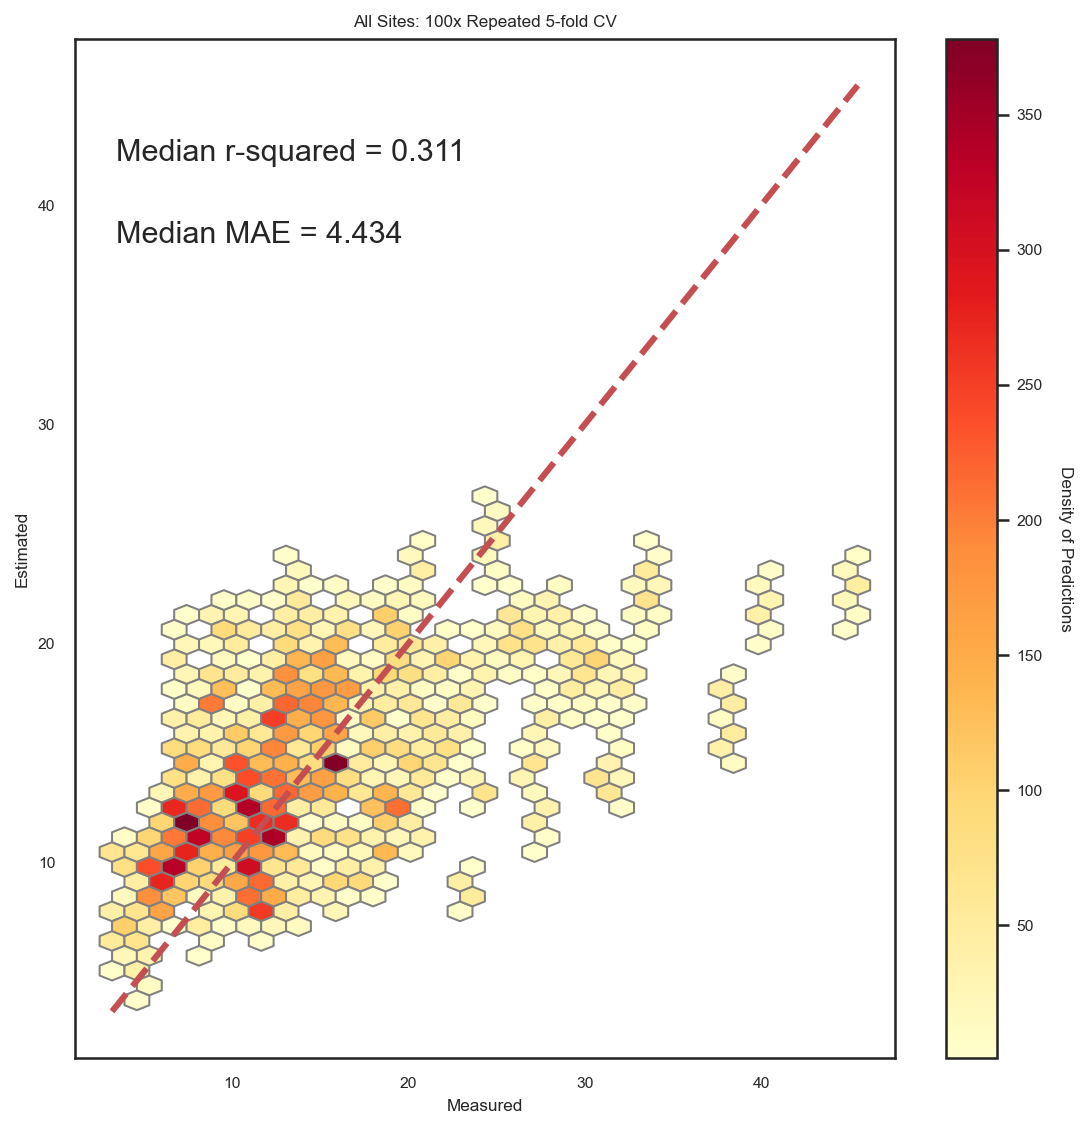

dict_keys(['Scaled Weights', 'Unscaled Weights', 'Unscaled Intercepts', 'Scaled regularizors', '# Well Determined Weights', 'Standard Deviations of Predictions', 'Predictions', 'Residuals', 'Predicted for Residuals'])


In [103]:
def cv_results_and_plot(unscaled_predictor_matrix, predictor_matrix, target, color_scheme: dict):

    # Error Containers
    predicted = []  # holds they predicted values of y
    y_ls = []  # holds the true values of y
    residuals = []

    hold_weights = {}  # container that holds the learned weight vectors
    hold_unscaled_weights = {}  # container that holds the inverted learned weight vectors
    hold_regularizors = {}  # container that holds the learned regularization constant
    hold_weight_certainty = {}  # holds our estimate of the number of "well-determined" parameters
    hold_intercept = {}  # holds the intercepts found
    hold_prediction_certainty = {}  # holds the std deviations of the predictive distributions
    hold_predicted = {}

    # Performance Metric Containers: I allow use the median because I want to be more robust to outliers
    r2_total_medians = []  # holds the k-fold median r^2 value. Will be length of 100 due to 100 repeats
    mae_total_medians = [] # holds the k-fold median Mean Absolute Error (MAE) value. Will be length of 100 due to 100 repeats

    # parameter holders
    weight_vector_ls = []  # holds the learned parameters for each k-fold test
    regularizor_ls = []  # holds the learned L2 regularization term for each k-fold test
    unscaled_w_ls = [] # holds the inverted weights to their natural scales
    intercept_ls = []  # holds the inverted intercept to its natural scale
    weight_certainty_ls = []  # holds the number of well-determinned parameters for each k-fold test
    prediction_certainty_ls = []  # holds the standard deviations of the predictions (predictive distributions)
    prediction_list = []

    for i in range(100):  # for 100 repeats
        try_cv = KFold(n_splits=5, shuffle=True)
        results_for_3fold = cross_validate(baymod, predictor_matrix, target.values.ravel(), cv=try_cv,
                                           scoring=('r2', 'neg_mean_absolute_error'),
                                           n_jobs=-1, return_estimator=True)
        # Scaled lists
        r2_ls = []
        mae_ls = []
        # Inversed lists
        r2_inv_ls = []
        mae_inv_ls = []
        # Certainty lists
        pred_certain = []
        pred_list = []
        w_certain = []

        for train_index, test_index in try_cv.split(X):
            X_train, X_test = predictor_matrix.iloc[train_index], predictor_matrix.iloc[test_index]
            y_train, y_test = target.iloc[train_index], target.iloc[test_index]
            # Fit the model
            baymod.fit(X_train, y_train.values.ravel())
            # collect unscaled parameters
            unscaled_weights, intercept = unscaled_weights_from_Xstandardized(unscaled_predictor_matrix[bestfeatures],
                                                                              baymod)
            unscaled_w_ls.append(unscaled_weights)

            intercept_ls.append(intercept)
            # Collect scaled parameters
            weights = baymod.coef_
            weight_vector_ls.append(abs(weights))  # Take the absolute values of weights for relative feature importance
            regularizor = baymod.lambda_ / baymod.alpha_
            regularizor_ls.append(regularizor)
            design_m = np.asarray(X_train)
            eigs = np.linalg.eigh(baymod.lambda_ * (design_m.T @ design_m))
            weight_certainty = []
            for eig in eigs[0]:
                weight_certainty.append(eig/(eig + baymod.lambda_))
            weight_certainty = np.sum(weight_certainty)
            w_certain.append(weight_certainty)
            # Make our predictions for y
            ypred, ystd = baymod.predict(X_test, return_std=True)
            # Save average std on each prediction
    #         pred_certain.append(np.mean(ystd))

            pred_list += list(ypred)
            pred_certain += list(ystd)


            # Metrics for scaled y: particularly for MAE
            r2 = r2_score(y_test, ypred)
            r2_ls.append(r2)
            mae = mean_absolute_error(y_test, ypred)
            mae_ls.append(mae)
            # Metrics for inversed y: particularly for MAE
            r2_inv = r2_score(y_test, ypred)
            r2_inv_ls.append(r2_inv)
            mae_inv = mean_absolute_error(y_test, ypred)
            mae_inv_ls.append(mae_inv)

        # Average certainty in predictions
        prediction_certainty_ls.append(pred_certain)
        prediction_list.append(pred_list)

        weight_certainty_ls.append(np.mean(w_certain))
        # Average predictions over the Kfold first: scaled
        r2_median = np.median(r2_ls)
        r2_total_medians.append(r2_median)
        mae_median = np.median(mae_ls)
        mae_total_medians.append(mae_median)

        predicted = predicted + list(cross_val_predict(baymod, predictor_matrix, target.values.ravel(), cv=try_cv))
        residuals = residuals + list(target.values.ravel() - cross_val_predict(baymod, predictor_matrix, 
                                                                          target.values.ravel(), cv=try_cv))
        y_ls += list(target.values.ravel())

    # Add each of the model parameters to a dictionary
    weight_df = pd.DataFrame(weight_vector_ls, columns=bestfeatures)
    unscaled_weight_df = pd.DataFrame(unscaled_w_ls, columns=bestfeatures)
    
    # Now calculate the mean of th kfold means for each repeat: scaled accretion
    r2_final_median = np.median(r2_total_medians)
    mae_final_median = np.median(mae_total_medians)

    fig, ax = plt.subplots(figsize=(9, 9))
    hb = ax.hexbin(x=y_ls,
                   y=predicted,
                   gridsize=30, edgecolors='grey',
                   cmap=color_scheme['cmap'], mincnt=1)
    ax.set_facecolor('white')
    ax.set_xlabel("Measured")
    ax.set_ylabel("Estimated")
    ax.set_title("All Sites: 100x Repeated 5-fold CV")
    cb = fig.colorbar(hb, ax=ax)
    cb.ax.get_yaxis().labelpad = 15
    cb.set_label('Density of Predictions', rotation=270)
    ax.plot([target.min(), target.max()], [target.min(), target.max()],
        color_scheme['line'], lw=3)

    ax.annotate("Median r-squared = {:.3f}".format(r2_final_median), xy=(20, 450), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    ax.annotate("Median MAE = {:.3f}".format(mae_final_median), xy=(20, 410), xycoords='axes points',
                bbox=dict(boxstyle='round', fc='w'),
                size=15, ha='left', va='top')
    plt.show()
    
    return {
        "Scaled Weights": weight_df, "Unscaled Weights": unscaled_weight_df, "Unscaled Intercepts": intercept_ls, 
        "Scaled regularizors": regularizor_ls, "# Well Determined Weights": weight_certainty_ls, 
        "Standard Deviations of Predictions": prediction_certainty_ls, "Predictions": prediction_list, 
        "Residuals": residuals, "Predicted for Residuals": predicted
    }


results_dict = cv_results_and_plot(phi, X, y, {'cmap': 'YlOrRd', 'line': 'r--'})
# lets look at the keys of the returned results dictionary for future reference
print(results_dict.keys())


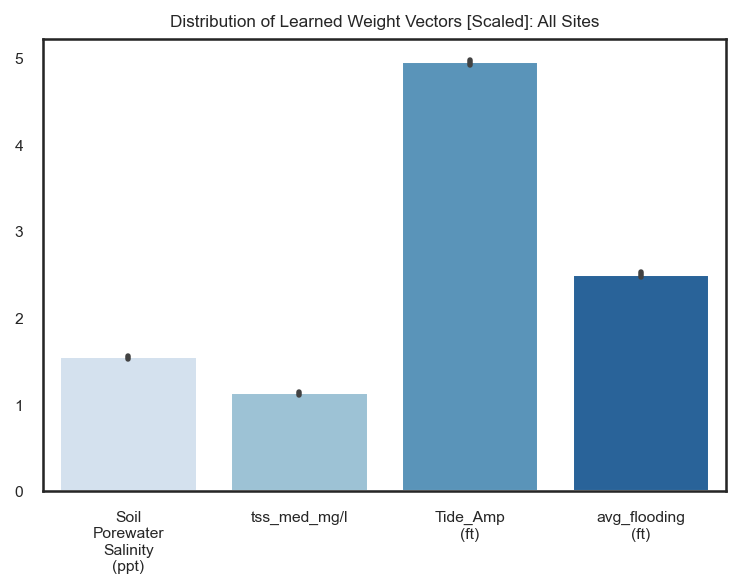

In [104]:
def wrap_labels(ax, width, break_long_words=False):
    """
    https://medium.com/dunder-data/automatically-wrap-graph-labels-in-matplotlib-and-seaborn-a48740bc9ce
    """
    labels = []
    for label in ax.get_xticklabels():
        text = label.get_text()
        labels.append(textwrap.fill(text, width=width,
                      break_long_words=break_long_words))
    ax.set_xticklabels(labels, rotation=0)

    
# Lets plot the feature importances from the collected scaled weights
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Scaled]: All Sites')
sns.barplot(data=results_dict['Scaled Weights'], palette="Blues")
wrap_labels(ax, 10)
plt.show()

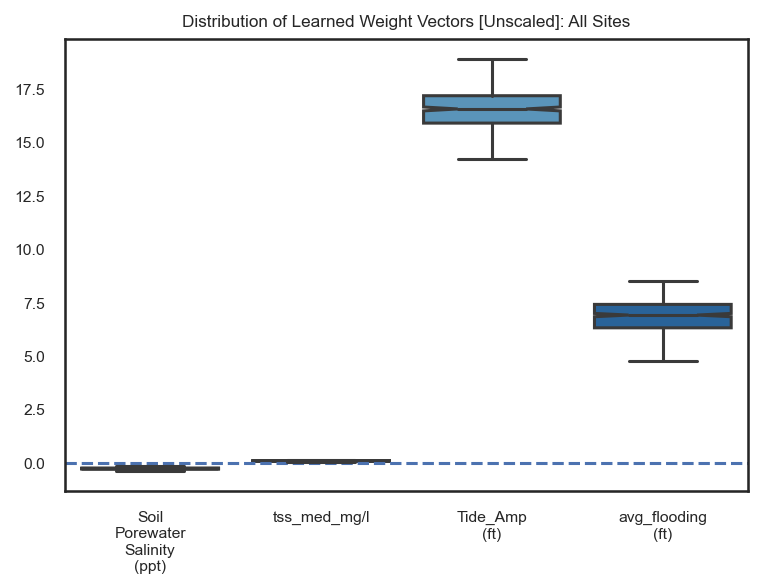

Soil Porewater Salinity (ppt)   -0.022517
tss_med_mg/l                     0.004858
Tide_Amp (ft)                    1.184398
avg_flooding (ft)                0.405258
dtype: float64

In [105]:
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Unscaled]: All Sites')
ax.axhline(0, ls='--')
boxplot = sns.boxplot(data=results_dict['Unscaled Weights'], notch=True, showfliers=False, palette="Blues")
wrap_labels(ax, 10)
plt.show()

hold_unscaled_weights['All'].median()

The boxplots represent the whole range of 500 learned coefficents for each of the 100x repeated 5-fold cross validation sets. From the medians of these boxplots we see that only soil porewater salinity is negatively related to accretion, while the three other predictors are positively related to accretion. To interpret these coefficents we can use, for example, "a one foot increase in the average flood depth results in a 6.89 mm increase in the accretion rate for a bayesian ridge regression model." 

Now let's look at some other calcualted parameters specifically for the Bayesian Ridge Regression. First lets look at the distribution of the standard deviations for y. 

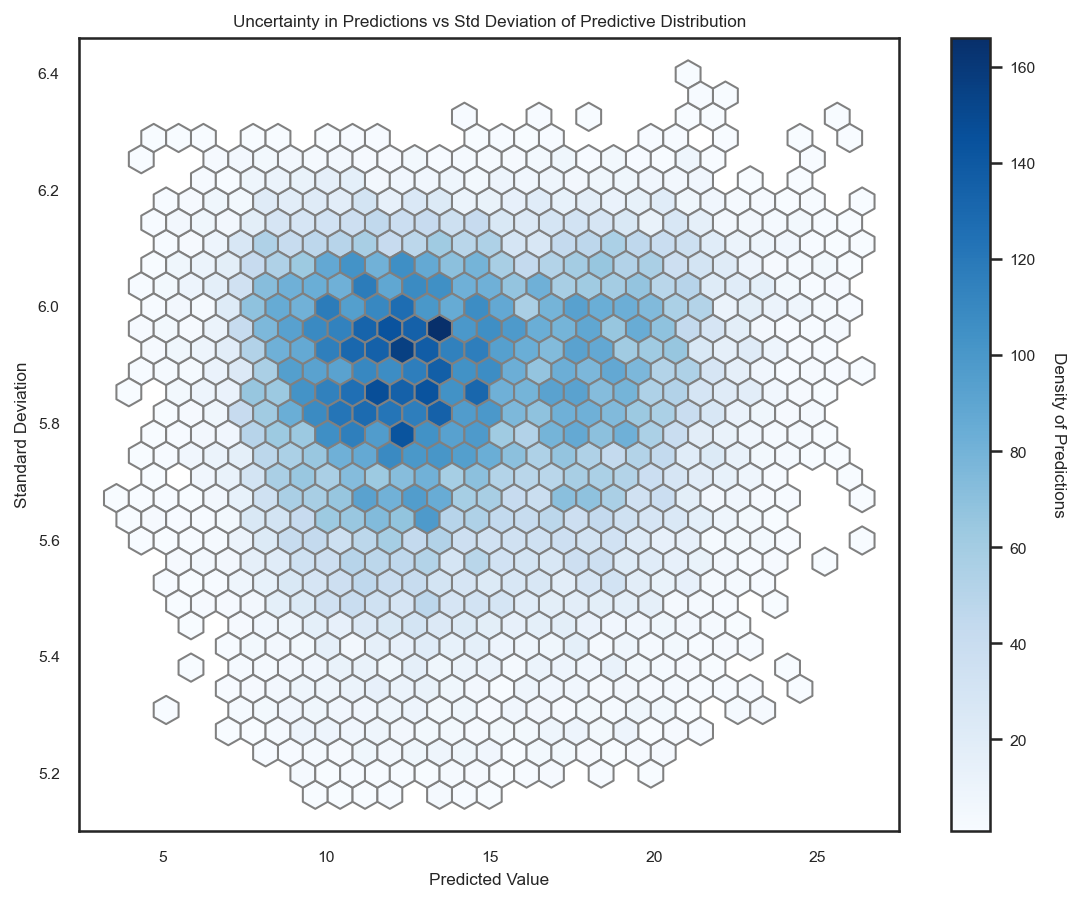

In [106]:
fig, ax = plt.subplots(figsize=(9, 7))
hb = ax.hexbin(x=results_dict['Predictions'],
               y=results_dict['Standard Deviations of Predictions'],
               gridsize=30, edgecolors='grey',
               cmap='Blues', mincnt=1)
ax.set_facecolor('white')
ax.set_xlabel("Predicted Value")
ax.set_ylabel("Standard Deviation")
ax.set_title("Uncertainty in Predictions vs Std Deviation of Predictive Distribution")
cb = fig.colorbar(hb, ax=ax)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Density of Predictions', rotation=270)
plt.show()

We see that the model retains a consistent uncertainty as the predicted value varies, indicating that there is no range of values for which model uncertainty increases. This is good because it means there is no lack of data for the whole distribution of our dependent variable....

### Residual Plots and Heteroscedasticity

Looking back at the one-to-one plot, I think we can make our model better and, thus, gain more confidence in its predictions. But, how? Looking at residual plots helps us assess whether a linear model is appropriate to model the data and give us an idea about how we can improve the model by looking at trends withi the residuals. We actually already calcualted the residuals for every cross validation run, so all we need to do know it plot it.

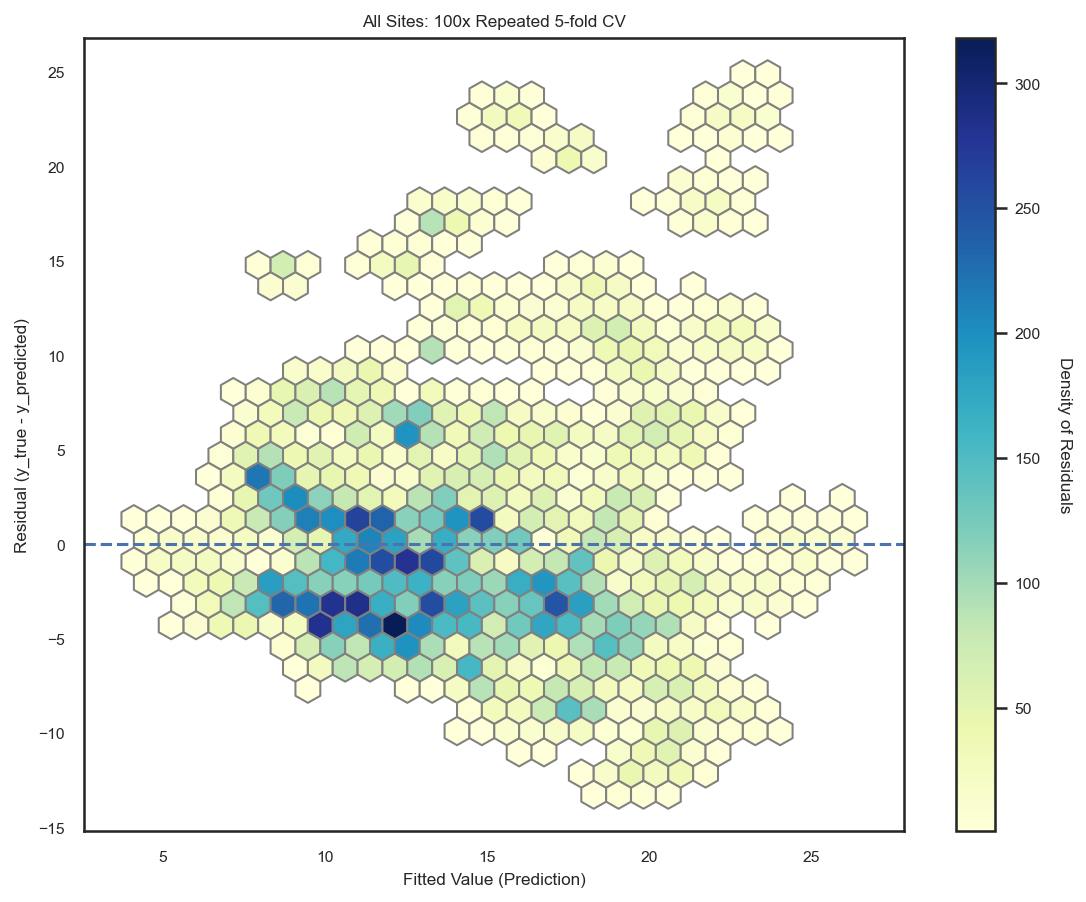

In [107]:
fig, ax = plt.subplots(figsize=(9, 7))
hb = ax.hexbin(x=results_dict['Predicted for Residuals'],
               y=results_dict['Residuals'],
               gridsize=30, edgecolors='grey',
               cmap='YlGnBu', mincnt=1)
ax.set_facecolor('white')
ax.set_xlabel("Fitted Value (Prediction)")
ax.set_ylabel("Residual (y_true - y_predicted)")
ax.set_title("All Sites: 100x Repeated 5-fold CV")
cb = fig.colorbar(hb, ax=ax)
cb.ax.get_yaxis().labelpad = 15
cb.set_label('Density of Residuals', rotation=270)
ax.axhline(0.0, linestyle='--')
plt.show()

Let's review how to interpret residuals. First, for a linear regression model, the residuals should look randomly distributed around the horizontal zero line. This indicates that our linear model accuractly captures the data. If our data is likely non-linear, we may see certain trends in the residuals, for example, a parabolic form of the residuals. Heteroscedasticity is when there is an increase in the variation of the residuals as the predicted value (x-axis) increases. 

In our plot, we can see some weak heteroscedastic trends. In order to mitigate this affect, we can take the natural log of our dependent variable accretion, then fit a a regression. So lets re-run the same code from above, but on log accretion.

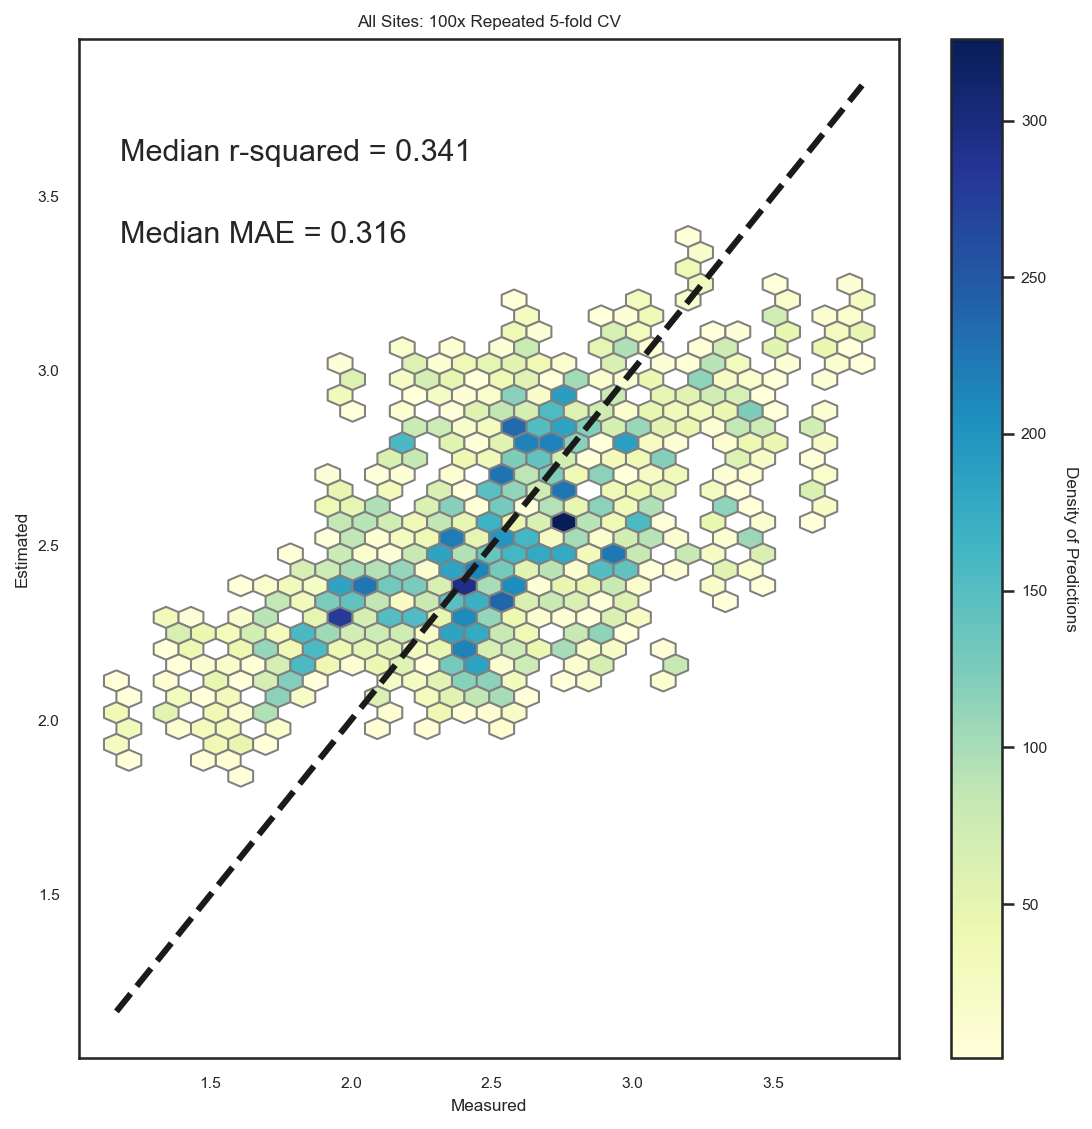

In [108]:
# Log(y) and make a new variable for it
y_log = np.log(y)
# use the same function as above to get results
log_results_dict = cv_results_and_plot(phi, X, y_log, {'cmap': 'YlGnBu', 'line': 'k--'})


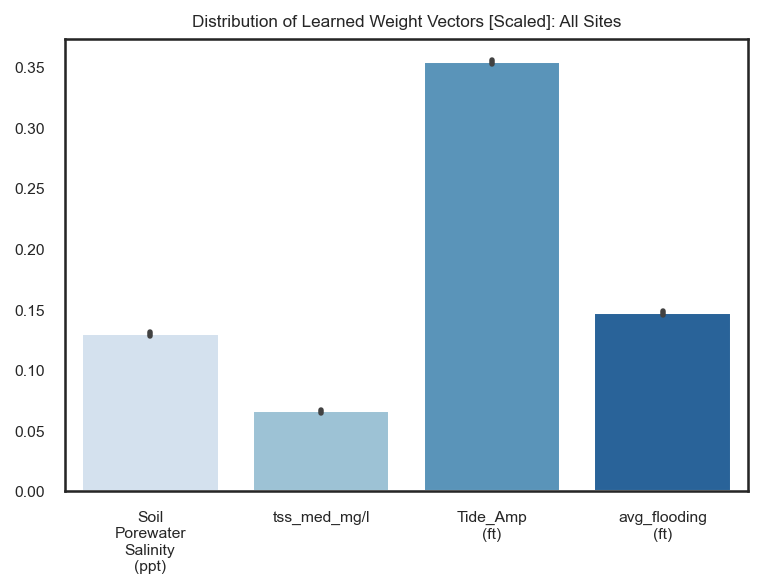

In [109]:
# Lets plot the feature importances from the collected unscaled weights
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Scaled]: All Sites')
sns.barplot(data=log_results_dict['Scaled Weights'], palette="Blues")
wrap_labels(ax, 10)
plt.show()

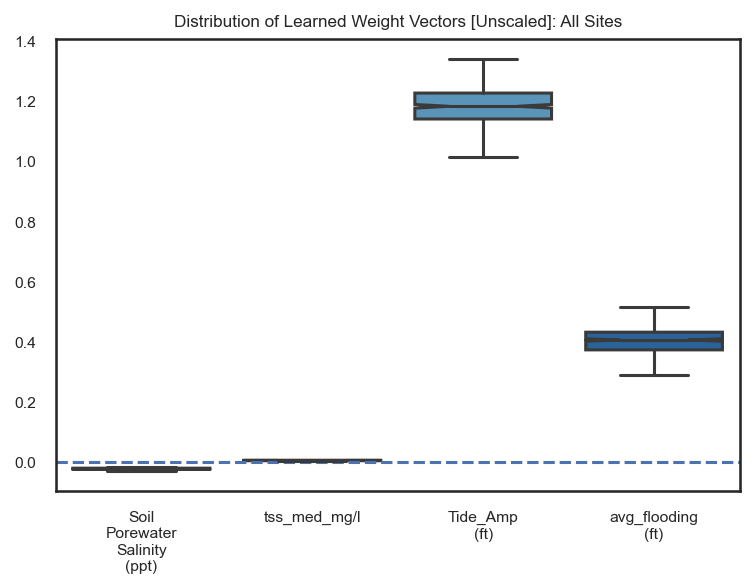

Soil Porewater Salinity (ppt)   -0.022517
tss_med_mg/l                     0.004858
Tide_Amp (ft)                    1.184398
avg_flooding (ft)                0.405258
dtype: float64

In [110]:
sns.set_theme(style='white', rc={'figure.dpi': 147}, font_scale=0.7)
fig, ax = plt.subplots(figsize=(6, 4))
ax.set_title('Distribution of Learned Weight Vectors [Unscaled]: All Sites')
ax.axhline(0, ls='--')
boxplot = sns.boxplot(data=log_results_dict['Unscaled Weights'], notch=True, showfliers=False, palette="Blues")
wrap_labels(ax, 10)
plt.show()

hold_unscaled_weights['All'].median()

So, when we log the dependent variable, we only increase the r^2 value by 4%. Logging the dependet variable means we have to change our interpretation of the weights. We know interpret the weights in terms of percent increases in y. For example, "a 1 foot increase in flood depth results in a 0.4% increase in the accretion rate at a CRMS site." This makes the interpretation a little more complicated, so it may not be worth doing this log in our case. However, it is still good to know this option exists and can improve model performance.

## Extreme Gradient Boosting (XGBoost)

### Intuition behind the XGBoost Algorithm

This model was first introduced in 2016 by  in the paper ... . See link here: 

An important note about the XGBoost model is that scale and the number of features does not affect model performance. Therefore, we can give the model our full, unscaled dataset. This will then allow us to see the relative importance of every feature in the dataset in our analysis later in te tutorial.

### XGBoost Model Selection, Evaluation, and Implementation

To create our XGBoost model we need to find the optimal hyperparameters of the model for the data we have. There is not an easy mathematical method to solve for these hyperparameters as there was in Bayesian Ridge, so we have to defer to testing different combinations of hyperparameters, conducting a cross validation assessment of the model with each set of selected hyperparameters, then choosing the set of hyperparameters that achieves the highest cross validation score. 

This is not ideal for our intuition about the model, but is often used in practice and often converges on the true set of hyperparamters for the data. XGBoost has many different parameters we can set, however, I will only find some of the most salient parameters for the model. But, you can see the full list of parameters here: https://xgboost.readthedocs.io/en/stable/python/python_intro.html

Below I will initialize my parameter dictionary that I will then feed into a grid search algorithm provided by sklearn.

In [111]:
phi.columns

Index(['Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI',
       'tss_med_mg/l', 'windspeed', 'Tide_Amp (ft)', 'avg_flooding (ft)',
       '90%thUpper_flooding (ft)', '10%thLower_flooding (ft)',
       'std_deviation_avg_flooding (ft)', 'avg_percentflooded (%)',
       'land_lost_km2', 'log_distance_to_water_km',
       'log_distance_to_river_km'],
      dtype='object')

In [112]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

# Create XGBoost model: 
xgbmodel = xgb.XGBRegressor()
params = {
    'learning_rate': [0.10, 0.20, 0.30, 0.40, 0.6, 1, 5, 10],
    'min_child_weight': [1, 3, 5, 7, 9, 11, 15, 20],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.7, 8, 0.9],
    'max_depth': [3, 4, 5, 10, 15, 20, 25, 30, 40, 50, 60, 70, 80, 90, 100],
    'n_estimators': [5, 10, 25, 50, 100, 400, 500, 600, 700, 800, 1000],
    'reg_lambda': [0, 0.4, 0.6, 0.8, 1, 10, 33, 50, 100],
    'gamma': [0, 0.4, 0.6, 0.8, 1, 10, 33, 50, 100]
}

# Search the parameter space with a grid search algorithm
searcher = RandomizedSearchCV(xgbmodel, param_distributions=params, n_iter=100, scoring='neg_mean_squared_error', n_jobs=-1, cv=5,
                              verbose=1)
# XGBoost doe snot assume normality of the predictors so lets put the log transformaed variables back into their original units
phi['log_distance_to_water_km'] = np.exp(phi['log_distance_to_water_km'])
phi['log_distance_to_river_km'] = np.exp(phi['log_distance_to_river_km'])
phi = phi.rename(columns={'log_distance_to_water_km': 'distance to water km',
                          'log_distance_to_river_km': 'distance to river km'})
# Fit to all the data
searcher.fit(np.asarray(phi), np.asarray(target.values.ravel()))
# Extract the best model
bestXGB = searcher.best_estimator_


Fitting 5 folds for each of 100 candidates, totalling 500 fits



80 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/xgboost/core.py", line 506, in inner_f
    return f(**kwargs)
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/xgboost/sklearn.py", line 789, in fit
    self._Booster = train(
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/

We are going to again use repeated cross validation to assess the true model performance (after we already have the hyparameters). However, rather than writing out the cross validation code explicity in a for-loop as I did for Bayesian Ridge, I will use a function from scikit learn called "RepeatedKFold" and "cross_val_score." These functions are easy to use and give us the same result as what I did above. The reason I am using these functions is because there are not any intuitively interpretable model parameters to extract from XGBoost, so there is no need to collect them per iteration as I did above. So, the model implementation code will be short and simple :)

NOTE: Since we have essentially shown the model some of our test set when picking hyparameters, our results will be slighlty optimistic. This is okay only if we recognize what we are doing.

In [113]:
rcv = RepeatedKFold(n_splits=5, n_repeats=100, random_state=123)
# scores = cross_val_score(rs_model.best_estimator_, predictors, target.values.ravel(), scoring='r2',
#                          cv=rcv, n_jobs=-1)
scores = cross_validate(bestXGB, np.asarray(phi), np.asarray(target.values.ravel()), cv=rcv, 
                        scoring=('r2', 'neg_mean_absolute_error'), return_train_score=True)
print("Median XGB R^2 score", np.median(scores['test_r2']))
print("Median XGB MAE score", abs(np.median(scores['test_neg_mean_absolute_error'])))

Median XGB R^2 score 0.2718300800378165
Median XGB MAE score 4.462507866516097


### SHAP Analysis of XGBoost

In python, there is a handy package to explain how your model makes predictions post training. This is called "post-hoc" explainability by .... . The package is called SHAP and it is easy to install and use on a variety of different models. 

The analysis that I present will show how to use some basic functions in the package to gather feature importance and feature dependence plots. However, there is a variety of other types of analysis one could do, depending on the model, that are described in the docs: https://shap.readthedocs.io/en/latest/

I am only going to do a SHAP analysis on the XGBoost model because we have already assessed the relative feature importances of the bayesian ridge model through the scaled weight coefficents. We also already now how the outcome depends on the features. Since bayesian ridge regression is a linear model, we know that there is a lienar relationship between the features and the outcome with a slope determined by the weight coefficent and an intercept determined by the bias parameter $w_0$

Permutation explainer: 253it [00:25,  5.72it/s]                                 


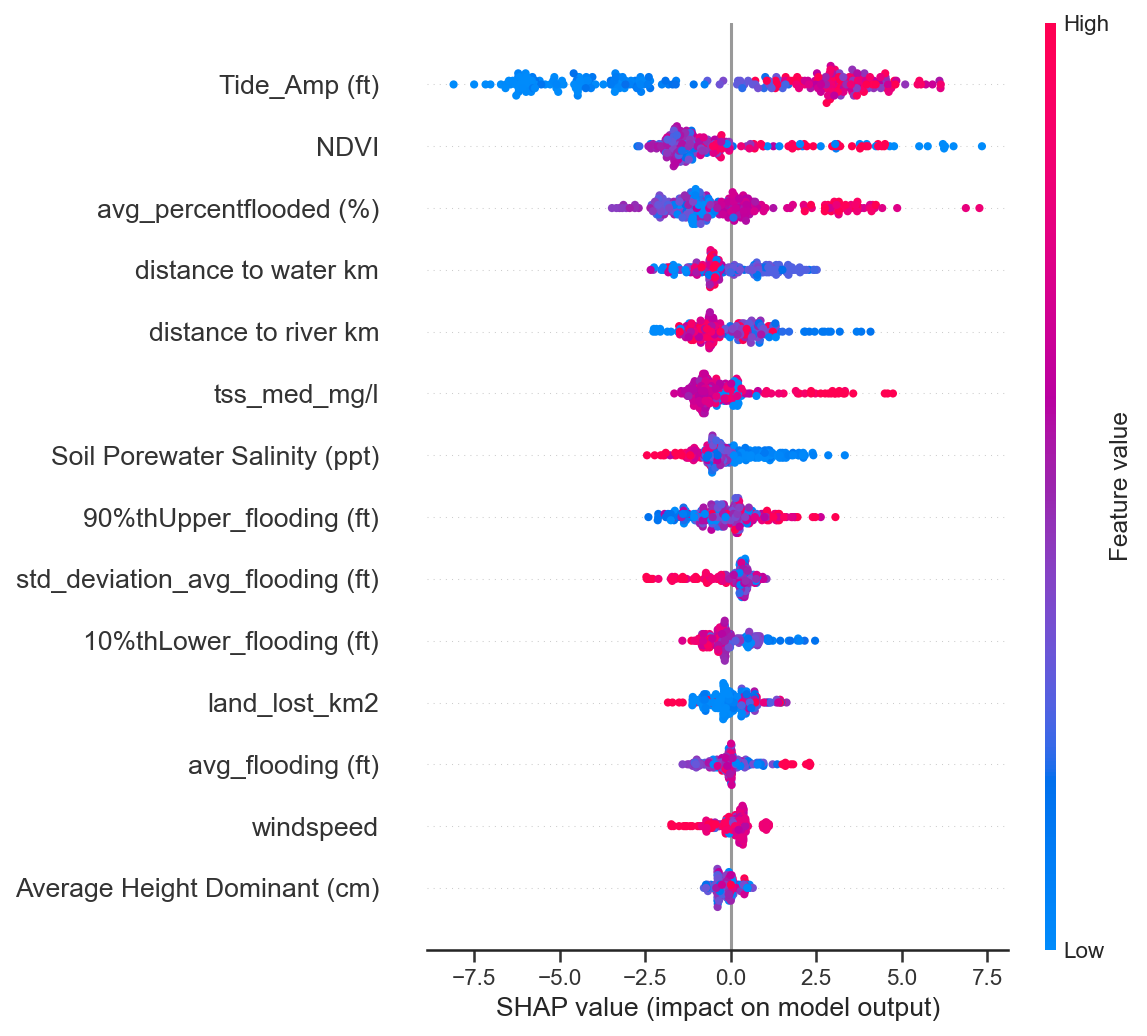

In [114]:
# Shap Analysis
X500 = shap.utils.sample(phi, 500) # randomly sample 100 instances for use as the background distribution

explainer_ebm = shap.Explainer(bestXGB.predict, X500)  # explain a random sample of the data
shap_values_ebm = explainer_ebm(phi)

# the waterfall_plot shows how we get from explainer.expected_value to model.predict(X)[sample_ind]
shap.summary_plot(shap_values_ebm, features=phi, feature_names=phi.columns)

Notice that the identified most important variables are simlar to the most important variables in linear regression. However, they are slighly different as these two models are very different from each other and use the predictors in very different ways. 

Let's take a look at a feature importance chart considering potentially related variables.

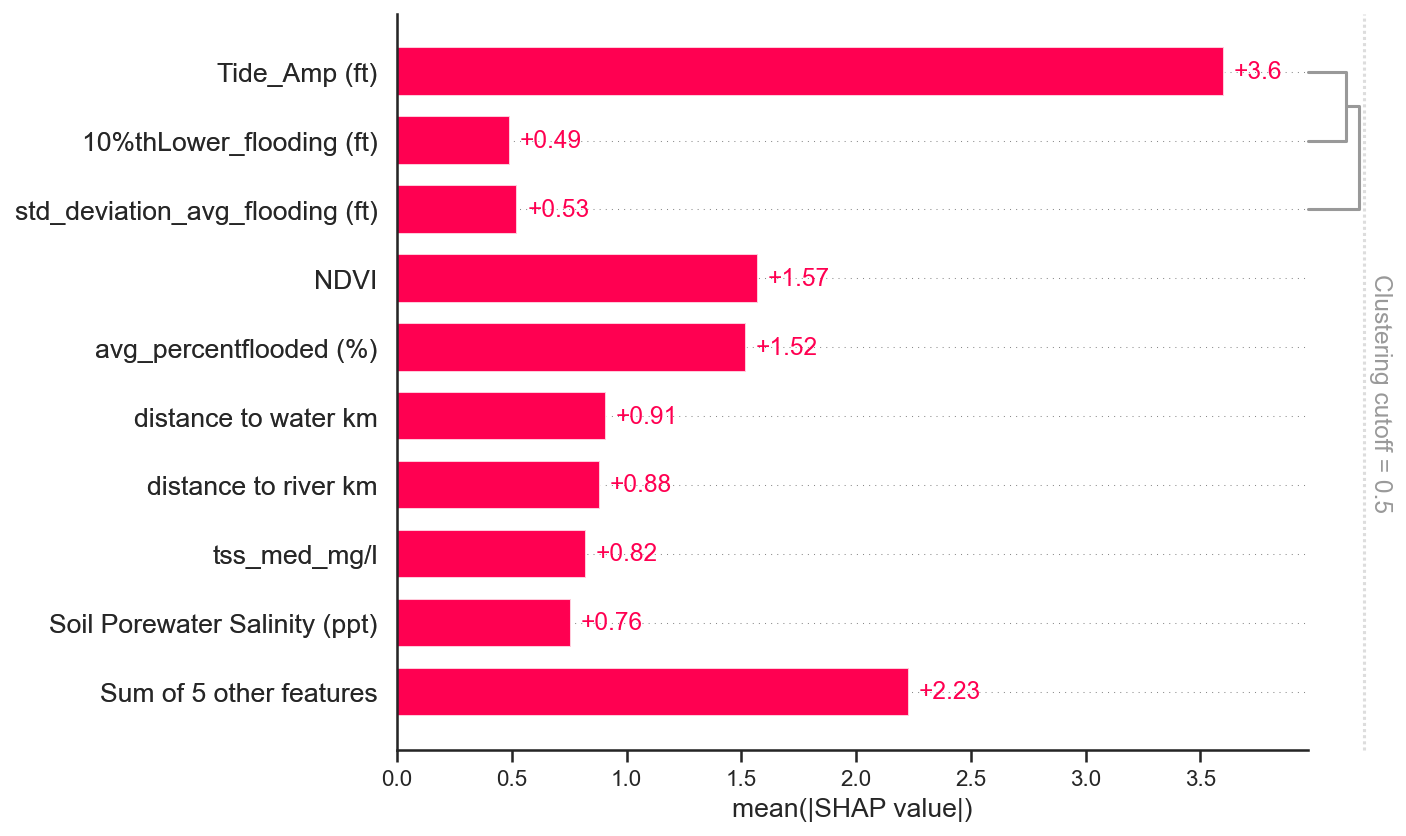

Index(['Soil Porewater Salinity (ppt)', 'Average Height Dominant (cm)', 'NDVI',
       'tss_med_mg/l', 'windspeed', 'Tide_Amp (ft)', 'avg_flooding (ft)',
       '90%thUpper_flooding (ft)', '10%thLower_flooding (ft)',
       'std_deviation_avg_flooding (ft)', 'avg_percentflooded (%)',
       'land_lost_km2', 'log_distance_to_water_km',
       'log_distance_to_river_km'],
      dtype='object')


In [115]:
clustering = shap.utils.hclust(phi, target)
shap.plots.bar(shap_values_ebm, clustering=clustering)
print(predictors.columns)

This is interesting. SHAP has identified the 10th% Lower percentile of flood depth and the standard deviation of flooding to be related to the tidal amplitude, but, interestingly, not the 90th% Upper percentile of flood depth or the average flood depth. 

Lets now check the dependence plots to see how the most important features influence the predicted outcome.

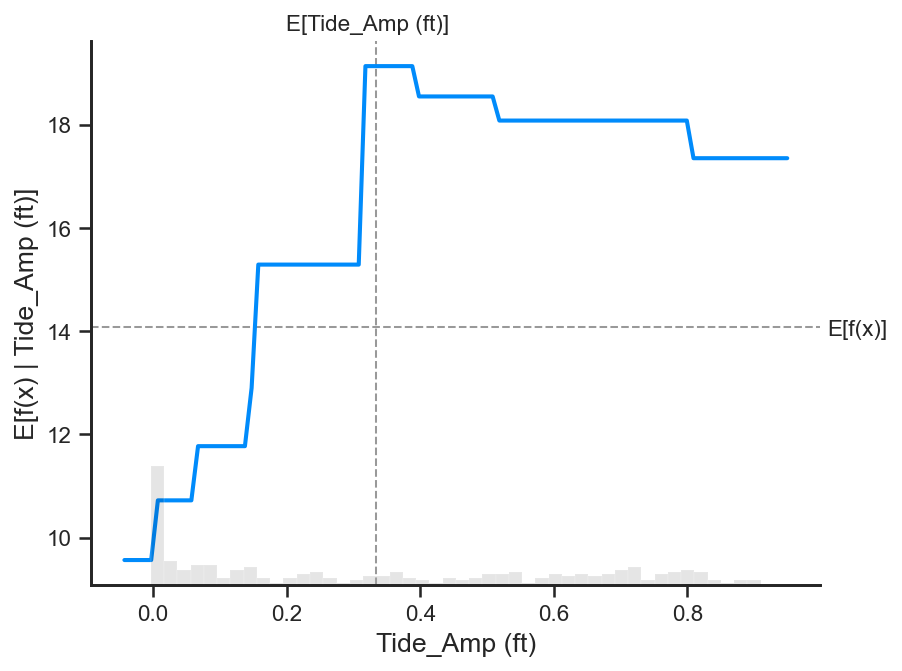

In [116]:
shap.partial_dependence_plot(
    'Tide_Amp (ft)', bestXGB.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)

From the dependence plot, we see that positive logarithmic relationship with accretion rate in our model.

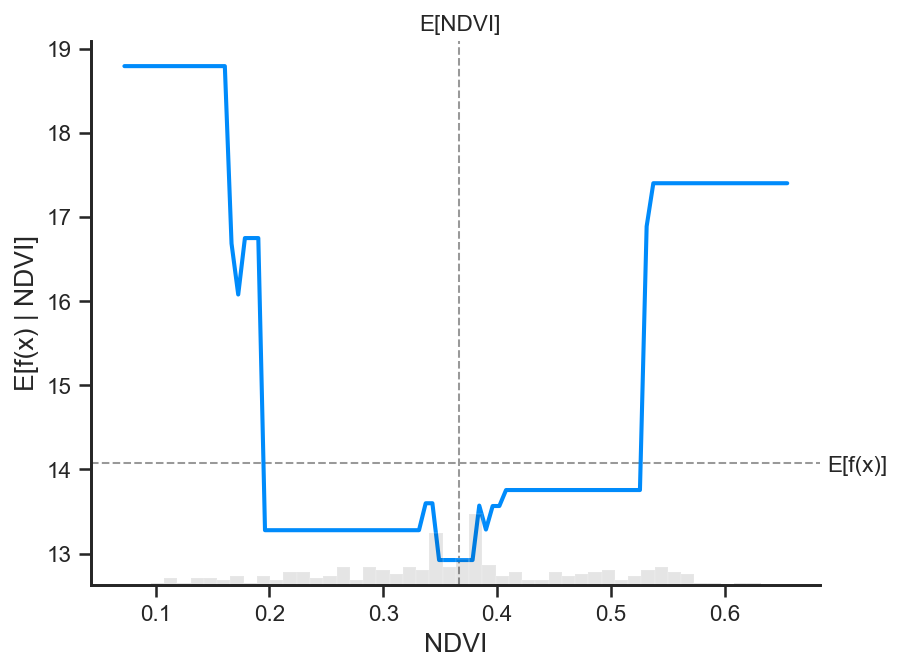

In [117]:
shap.partial_dependence_plot(
    'NDVI', bestXGB.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)

This U-shape relationship with NDVI and expected accretion is particularly interesting. Why do sites with relatively lower NDVI, NDVI < 0.3, have a negative correlation with accretion while sites with a higher NDVI, NDVI > 0.4, have a positive correlation to accretion? We will look into this further after the rest of our dependence plots

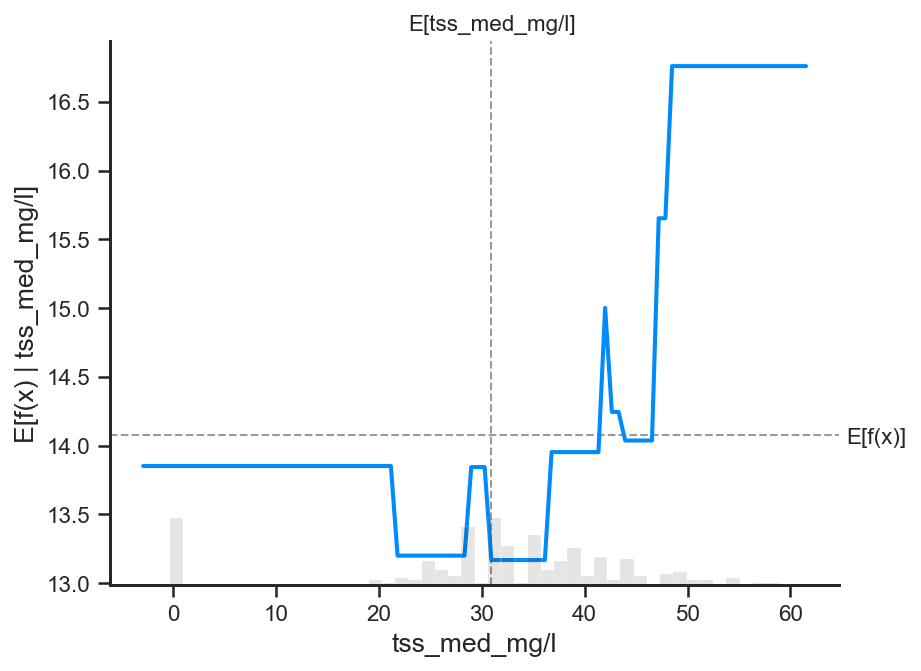

In [118]:
shap.partial_dependence_plot(
    'tss_med_mg/l', bestXGB.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)

Here we see an S shaped function, where total suspended sediment concentrations of less than 40 mg/l have a weak negative influence on accretion. While suspended concentrations greater than 40 mg/l have a strong positive relationship towards expected accretion. 

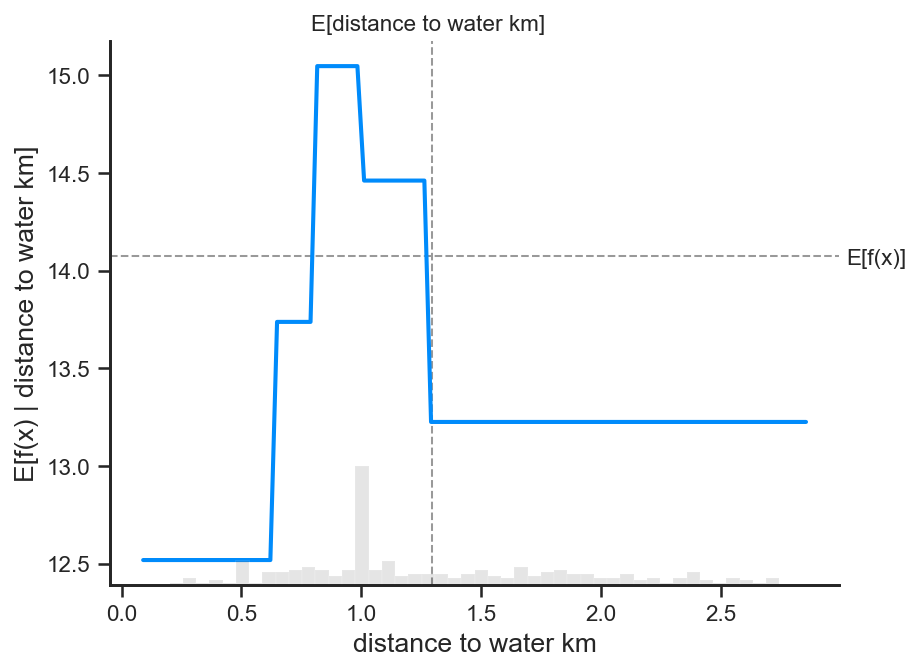

/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/

/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/

/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/

/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/python3.8/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/etiennechenevert/opt/anaconda3/envs/bayesian/lib/

In [119]:
shap.partial_dependence_plot(
    'distance to water km', bestXGB.predict, X500, ice=False,
    model_expected_value=True, feature_expected_value=True
)

This relationship is quite non linear and is hard to interpret. However, it does indicate that there may be other factors relating to distance from water that influence accretion.

## Explainable XGBoost Diagrams for the mean of the 10th, 25th, 50th, 75th, and 90th percentiles of predictions!